In [1]:
#!usr/bin/env python3
import numpy as np
import math
%matplotlib inline
import matplotlib
import itertools as __ITER__, functools as __FUN__
import matplotlib.pyplot as plt
import numpy.linalg as LA
from numpy.linalg import inv
import tqdm
from tqdm import trange

np.random.seed(1234)

In [2]:
#DEFINING CLASSES FOR LINEAR_REGRESSION, REGULARIZED REGRESSION AND BAYESIAN REGRESSION
class Regression(object):
    pass

class Linear_Regression(Regression):
    def __fit__(self, x_TRAIN: np.ndarray, y_TRAIN: np.ndarray):
#       w = (X.trasnpose() @ X)^(-1) @ X.transpose() @ y
#       HERE pinv is the PSEUDO INVERSE(MOORE PENROSE)
        self.wghtx_ = LA.pinv(x_TRAIN) @ y_TRAIN
        self.varx_ = np.mean(np.square(x_TRAIN @ self.wghtx_ - y_TRAIN))
        
    def predict(self, x: np.ndarray, retstd_: bool = False):
    #   retstd_ : returns the STD of the prediction if True
    #        y  : prediction for each sample    
        y = x @ self.wghtx_
        if retstd_:
            std_y = np.sqrt(self.varx_) + np.zeros_like(y)
            return y, std_y
        return y      

In [3]:
class Regularization_ADD_ON(Regression):
#    w_opt = argmin |t - X @ w| + lambda * |w|_2^2
#    here lambda is the regularization constant
    def __init__(self, lmbd__: float):
        self.lmbd__ = lmbd__

    #MAP_ESTIMATE
    def __fit__(self, x_TRAIN: np.ndarray, y_TRAIN: np.ndarray):
        eye = np.eye(np.size(x_TRAIN, 1))
        self.wghtx_ = np.linalg.solve(
            self.lmbd__ * eye + x_TRAIN.T @ x_TRAIN,
            x_TRAIN.T @ y_TRAIN,
        )

    def predict(self, x: np.ndarray):
        return x @ self.wghtx_

In [4]:
class Bayesian_Regression(Regression):
#    w ~ N(w|0, (1/alph__)*I)
#    y = X @ w
#    t ~ N(t|X @ w, 1/beta__)

    def __init__(self, alph__: float, beta__: float):
        self.alph__ = alph__
        self.beta__ = beta__
        self.mu_wghtx__ = None
        self.prec_wghtx__ = None

    def prior_given(self) -> bool:
        return self.mu_wghtx__ is not None and self.prec_wghtx__ is not None

    def get_prior(self, ndim: int) -> tuple:
        if self.prior_given():
            return self.mu_wghtx__, self.prec_wghtx__
        else:
            return np.zeros(ndim), self.alph__ * np.eye(ndim)

    def __fit__(self, x_TRAIN: np.ndarray, y_TRAIN: np.ndarray):
#       updating parameters given the training dataset        
        mu_prev__, prec_prev__ = self.get_prior(np.size(x_TRAIN, 1))

        prec_wghtx__ = prec_prev__ + self.beta__ * x_TRAIN.T @ x_TRAIN
        mu_wghtx__ = np.linalg.solve(
            prec_wghtx__,
            prec_prev__ @ mu_prev__ + self.beta__ * x_TRAIN.T @ y_TRAIN,
        )
        self.mu_wghtx__ = mu_wghtx__
        self.prec_wghtx__ = prec_wghtx__
        self.covar_wghtx__ = np.linalg.inv(self.prec_wghtx__)

    def predict(self, x: np.ndarray, retstd_: bool = False, smpl_SZ: int = None):
#        Return mean w/ STD of predictive distribution
#       return_std : flag to return standard deviation 
#       sample_size : no. of samples drawn from predictive distribution

#        y : mean of predictive distribution 
#        std_y : STD of the predictive distribution
#        smpl_y : samples from the predictive distribution
        if smpl_SZ is not None:
            smpl_wghtx__ = np.random.multivariate_normal(
                self.mu_wghtx__, self.covar_wghtx__, size = smpl_SZ,
            )
            smpl_y = x @ smpl_wghtx__.T
            return smpl_y
        y = x @ self.mu_wghtx__
        if retstd_:
            var_y = 1 / self.beta__ + np.sum(x @ self.covar_wghtx__ * x, axis = 1)
            std_y = np.sqrt(var_y)
            return y, std_y
        return y

In [5]:
def func(x: np.longdouble) -> np.longdouble: return np.sin(2 * np.pi * x)

def create_dataset(sampl_SZ: int):
    x_spprt = np.linspace(0, 1, num = sampl_SZ)
    target = func(x_spprt) + np.random.normal(scale = 1, size = x_spprt.shape)
    return x_spprt, target

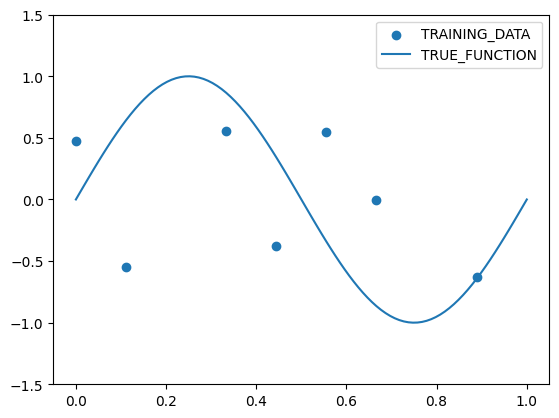

In [6]:
#DATASET FOR N = 10
x_TRAIN_v1, y_TRAIN_v1 = create_dataset(10)
x_TEST_v1 = np.linspace(0, 1, 100)
y_TEST_v1 = func(x_TEST_v1)

#plt.scatter(x_TRUE, y_TRUE)
plt.scatter(x_TRAIN_v1, y_TRAIN_v1, label="TRAINING_DATA")
plt.plot(x_TEST_v1, y_TEST_v1, label="TRUE_FUNCTION")
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()


In [7]:
#def gaussian_bf(x: np.longdouble, __mu: np.longdouble, __s: np.longdouble) -> np.longdouble:
#    return np.exp(((x - __mu) ** 2) / (2 * __s ** 2))

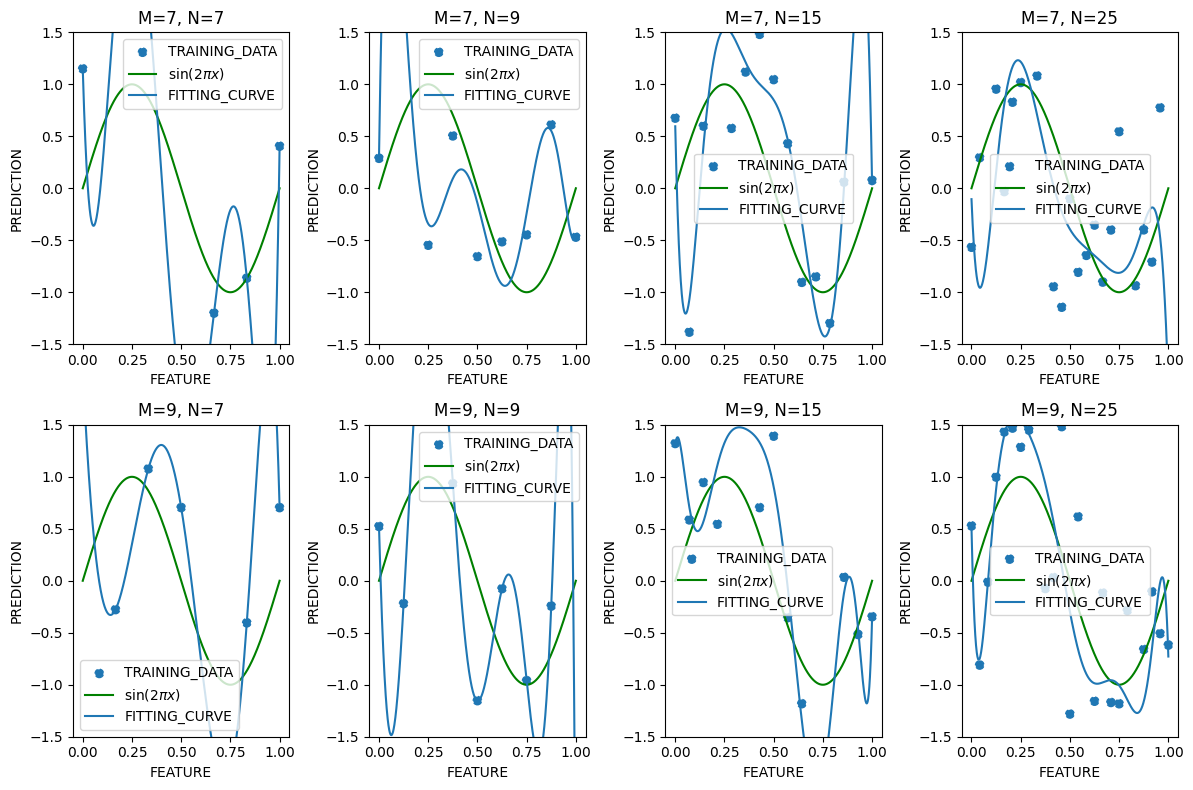

In [8]:
N_values = [7, 9, 15, 25]
M_values = [7, 9]

plt.figure(figsize=(12, 8))

for i, M in enumerate(M_values):
    for j, N in enumerate(N_values):
        x_TRAIN, y_TRAIN = create_dataset(N)
        x_TEST = np.linspace(0, 1, 1000)
        y_TEST = func(x_TEST)
        
#        featurx_ = polynomialization(M)
#        X_TRAIN = featurx_.transform(x_TRAIN)
#        X_TEST = featurx_.transform(x_TEST)

#       Here np.vander sets up linear equations to find the coefficients of the feature polynomial using Vandermonde matrix, which takes 
#       input x and consists of the powers of x from 0 to M(each row is a data point and each column is a power of x)
        X_TRAIN = np.vander(x_TRAIN, M + 1, increasing = True)
        X_TEST = np.vander(x_TEST, M + 1, increasing = True)

        model = Linear_Regression()
        model.__fit__(X_TRAIN, y_TRAIN)
        y_PRED = model.predict(X_TEST)

        plt.subplot(len(M_values), len(N_values), i * len(N_values) + j + 1)
        plt.title(f'M={M}, N={N}')
        plt.xlabel('FEATURE')
        plt.ylabel('PREDICTION')
        plt.scatter(x_TRAIN, y_TRAIN, label="TRAINING_DATA", linestyle = '--')
        plt.plot(x_TEST, y_TEST, c="g", label="$\sin(2\pi x)$")
        plt.plot(x_TEST, y_PRED, label="FITTING_CURVE")
        plt.ylim(-1.5, 1.5)
        plt.legend()
plt.tight_layout()
plt.show()


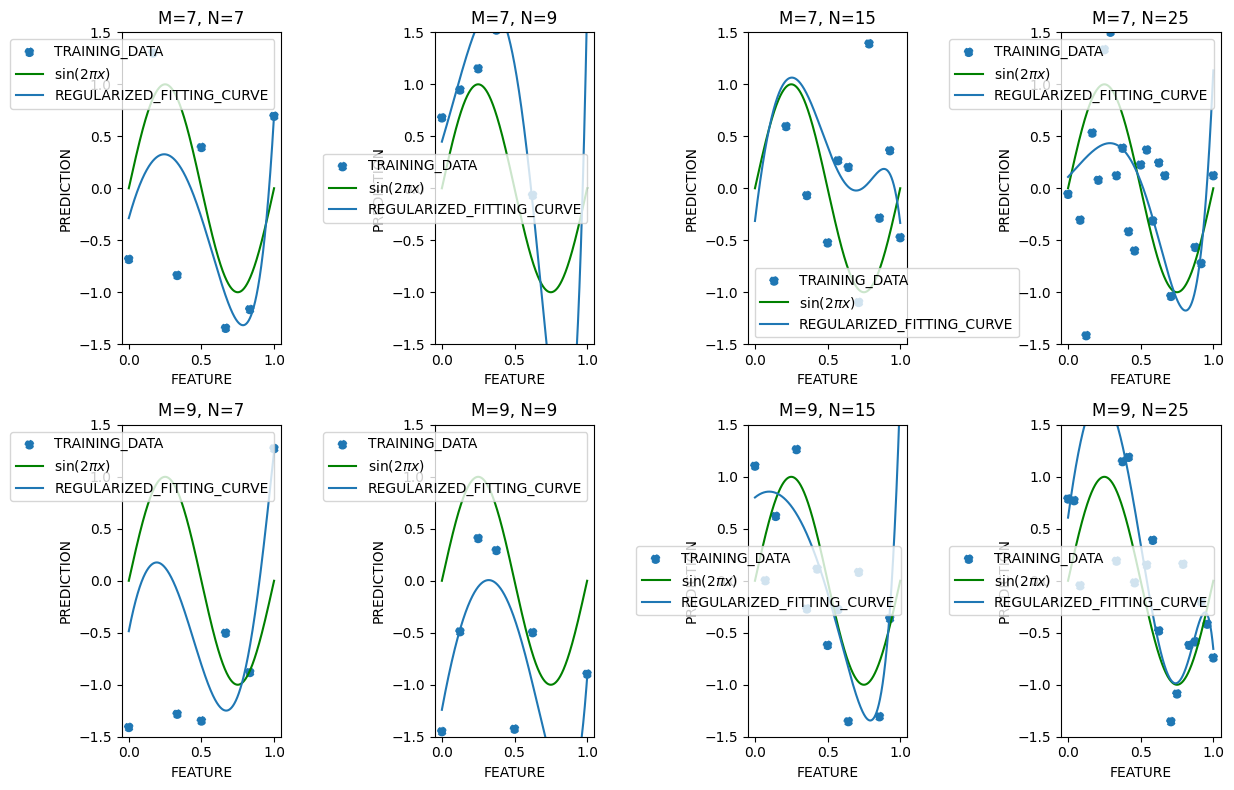

In [9]:
N_values = [7, 9, 15, 25]
M_values = [7, 9]

plt.figure(figsize=(12, 8))

for i, M in enumerate(M_values):
    for j, N in enumerate(N_values):
        x_TRAIN, y_TRAIN = create_dataset(N)
        x_TEST = np.linspace(0, 1, 1000)
        y_TEST = func(x_TEST)
#        featurx_ = polynomialization(M)
        
#        X_TRAIN = featurx_.transform(x_TRAIN)
#        X_TEST = featurx_.transform(x_TEST)
         
        X_TRAIN = np.vander(x_TRAIN, M + 1, increasing = True)
        X_TEST = np.vander(x_TEST, M + 1, increasing = True)
        
        model = Regularization_ADD_ON(lmbd__ = 1e-3)
        model.__fit__(X_TRAIN, y_TRAIN)
        y_PRED = model.predict(X_TEST)

        plt.subplot(len(M_values), len(N_values), i * len(N_values) + j + 1)
        plt.title(f'M={M}, N={N}')
        plt.xlabel('FEATURE')
        plt.ylabel('PREDICTION')
        plt.scatter(x_TRAIN, y_TRAIN, label="TRAINING_DATA", linestyle = '--')
        plt.plot(x_TEST, y_TEST, c="g", label="$\sin(2\pi x)$")
        plt.plot(x_TEST, y_PRED, label="REGULARIZED_FITTING_CURVE")
        plt.ylim(-1.5, 1.5)
        plt.legend()
plt.tight_layout()
plt.show()


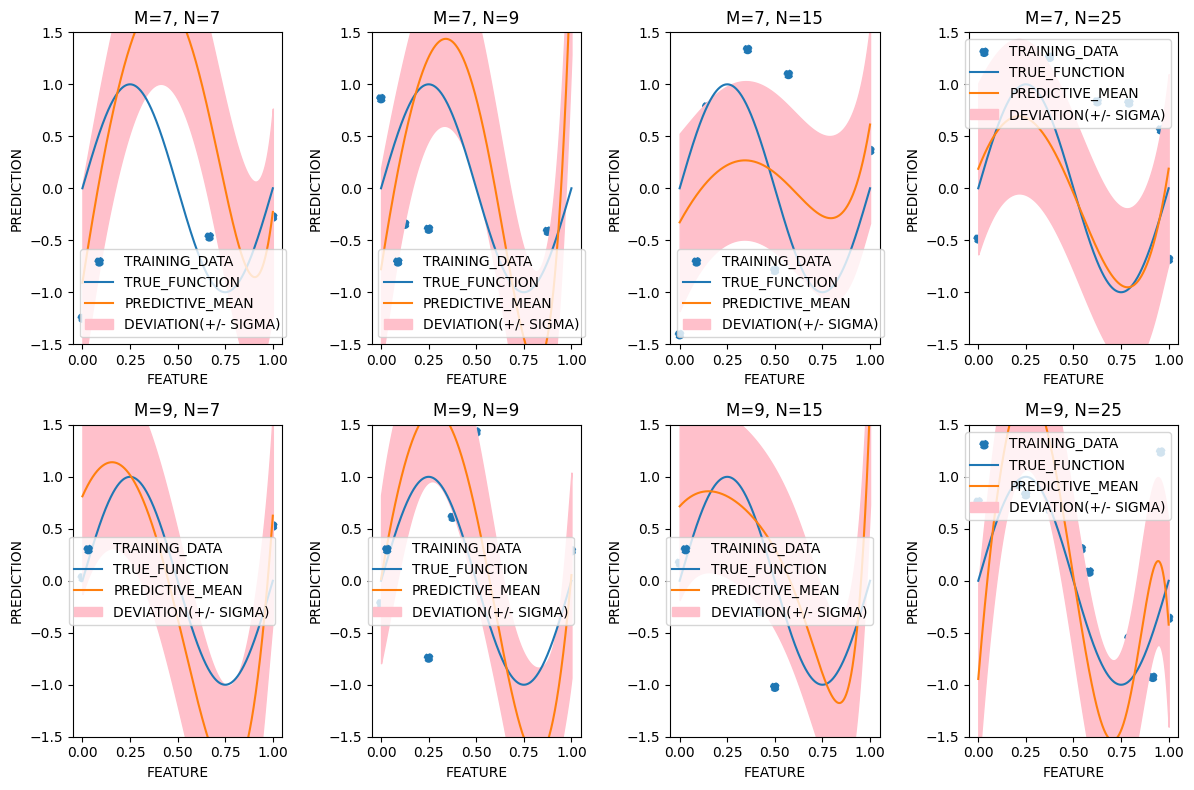

In [10]:
N_values = [7, 9, 15, 25]
M_values = [7, 9]

plt.figure(figsize=(12, 8))

for i, M in enumerate(M_values):
    for j, N in enumerate(N_values):
        x_TRAIN, y_TRAIN = create_dataset(N)
        x_TEST = np.linspace(0, 1, 1000)
        y_TEST = func(x_TEST)
#        featurx_ = polynomialization(M)  
#        X_TRAIN = featurx_.transform(x_TRAIN)
#        X_TEST = featurx_.transform(x_TEST)
         
        X_TRAIN = np.vander(x_TRAIN, M + 1, increasing = True)
        X_TEST = np.vander(x_TEST, M + 1, increasing = True)
        
        model = Bayesian_Regression(alph__ = 1e-2 * np.random.randn(), beta__ = 2)
        model.__fit__(X_TRAIN, y_TRAIN)
        y_PRED = model.predict(X_TEST)
        y, y_ERR = model.predict(X_TEST, retstd_ = True)

        plt.subplot(len(M_values), len(N_values), i * len(N_values) + j + 1)
        plt.title(f'M={M}, N={N}')
        plt.xlabel('FEATURE')
        plt.ylabel('PREDICTION')
        plt.scatter(x_TRAIN, y_TRAIN, label = "TRAINING_DATA", linestyle = '--')
        plt.plot(x_TEST, y_TEST, label = "TRUE_FUNCTION")
        plt.plot(x_TEST, y, label="PREDICTIVE_MEAN")
        plt.fill_between(x_TEST, y - y_ERR, y + y_ERR, color="pink", label="DEVIATION(+/- SIGMA)")
        plt.ylim(-1.5, 1.5)
        plt.legend()
plt.tight_layout()
plt.show()